In [88]:
import os, joblib
import numpy as np
import pandas as pd
import cvxpy as cp
import matplotlib.pyplot as plt
from arch import arch_model
import random as rnd
import tensorflow as tf
from tensorflow.keras.models import load_model

plt.style.use("seaborn-v0_8")

np.random.seed(42)
rnd.seed(42)
tf.random.set_seed(42)

In [89]:
BASE_PATH = r"E:\models\ResNet_Hybrid_v71"

model   = load_model(os.path.join(BASE_PATH,"resnet_model.keras"),compile=False)
encoder = load_model(os.path.join(BASE_PATH,"encoder_model.keras"),compile=False)

scalers = joblib.load(os.path.join(BASE_PATH,"scalers.pkl"))
meta    = joblib.load(os.path.join(BASE_PATH,"meta.pkl"))

assets = meta["assets"]
W      = meta["window"]
best_lag_ret = meta["best_lag_ret"]
best_lag_vol = meta["best_lag_vol"]

px_real = pd.read_csv(r"E:\data\stock_prices.csv",index_col="date",parse_dates=True).sort_index()

In [90]:
# ------------------------------------------------------------
# STANDARDIZE PRICES (USING TRAIN SCALERS)
# ------------------------------------------------------------
X_sc = pd.DataFrame(index=px_real.index, columns=assets)

for a in assets:
    X_sc[a] = scalers[a].transform(px_real[[a]]).ravel()


# ------------------------------------------------------------
# LATENT FEATURES (AUTOENCODER)
# ------------------------------------------------------------
X_lat = encoder.predict(X_sc.values, verbose=0)

# ------------------------------------------------------------
# GARCH FEATURES (EXACTLY AS TRAINING)
# ------------------------------------------------------------
garch_vol_list, garch_resid_list = [], []

for col in assets:
    rets = np.log(px_real[col]).diff().dropna()*100
    res = arch_model(rets,vol="Garch",p=1,q=1,dist="t")\
            .fit(update_freq=0,disp="off")

    vol = res.conditional_volatility.reindex(px_real.index).ffill()
    resid = (res.resid/res.conditional_volatility)\
            .reindex(px_real.index).ffill()

    garch_vol_list.append(vol.rename(f"{col}_garch_vol"))
    garch_resid_list.append(resid.rename(f"{col}_garch_resid"))

garch_feat_df = pd.concat(garch_vol_list+garch_resid_list,axis=1)

# ------------------------------------------------------------
# MARKET FEATURES (MATCH TRAINING NOTEBOOK)
# ------------------------------------------------------------
def realized_vol_series(s,w):
    return s.rolling(w,min_periods=w).std()

def make_lags(s,k):
    return pd.concat([s.shift(i) for i in range(1,k+1)],axis=1)

rets = np.log(px_real).diff()
mret = rets.median(axis=1)

lags_r = make_lags(mret,best_lag_ret)

vol_s = realized_vol_series(mret,5)
vol_l = realized_vol_series(mret,20)

lags_v = pd.concat([
    make_lags(vol_s,best_lag_vol),
    make_lags(vol_l,best_lag_vol)
],axis=1)

q = vol_s.quantile([0.33,0.66])

regimes = pd.concat([
    (vol_s<=q.iloc[0]).astype(int),
    ((vol_s>q.iloc[0])&(vol_s<=q.iloc[1])).astype(int),
    (vol_s>q.iloc[1]).astype(int)
],axis=1)

px_dm = px_real.mean(axis=1) \
        - px_real.mean(axis=1).rolling(120,min_periods=30).mean()

ema = px_real.mean(axis=1).ewm(span=20,min_periods=10).mean()

F_full = pd.concat(
    [lags_r,lags_v,regimes,px_dm,ema,garch_feat_df],
    axis=1
).ffill().dropna()

common_idx = F_full.index.intersection(px_real.index)

X_sc = X_sc.loc[common_idx]
X_lat = X_lat[X_sc.index.get_indexer(common_idx)]
F_full = F_full.loc[common_idx]

Z_full = np.hstack([X_lat,F_full.values])



# ------------------------------------------------------------
# BUILD SEQUENCES (W = 20)
# ------------------------------------------------------------
def build_sequences(Z,Xc,W):
    Zs,Xcs = [],[]
    for i in range(W,len(Z)):
        Zs.append(Z[i-W:i].reshape(-1))
        Xcs.append(Xc[i])
    return np.array(Zs),np.array(Xcs)

Z_seq,Xc_seq = build_sequences(Z_full,X_sc.values,W)
seq_index = X_sc.index[W:]

# ------------------------------------------------------------
# PREDICT SCALED PRICES
# ------------------------------------------------------------
y_hat_sc = model.predict([Z_seq,Xc_seq],verbose=0)

y_hat = pd.DataFrame(y_hat_sc,index=seq_index,columns=assets)

for a in assets:
    y_hat[a] = scalers[a].inverse_transform(y_hat[[a]])

# ------------------------------------------------------------
# RETURNS (FORECASTED vs REALIZED)
# ------------------------------------------------------------
P_t = px_real.loc[seq_index,assets]
P_tp1 = px_real.shift(-1).loc[seq_index,assets]

r_hat_df = (y_hat-P_t)/P_t
r_real_df = (P_tp1-P_t)/P_t

common_idx = r_hat_df.dropna().index\
                .intersection(r_real_df.dropna().index)

r_hat_df = r_hat_df.loc[common_idx]
r_real_df = r_real_df.loc[common_idx]

print("READY:",r_hat_df.shape,r_real_df.shape)

READY: (1909, 10) (1909, 10)


In [91]:
# ------------------------------------------------------------
# PRINT REBUILT FEATURE MATRIX (REFERENCE CHECK)
# ------------------------------------------------------------
print("\n=== FEATURE MATRIX CHECK ===")
print("F_full shape (rows, features):", F_full.shape)

print("\n--- Feature groups ---")
print("Return lags (mret):", lags_r.shape[1])
print("Volatility lags (vol5 + vol20):", lags_v.shape[1])
print("Regime dummies:", regimes.shape[1])
print("Market features (dm + ema):", 2)
print("GARCH features:", garch_feat_df.shape[1])

print("\nTOTAL FEATURES:", F_full.shape[1])

print("\n--- Feature names ---")
for i, c in enumerate(F_full.columns, 1):
    print(f"{i:02d}: {c}")


=== FEATURE MATRIX CHECK ===
F_full shape (rows, features): (1920, 55)

--- Feature groups ---
Return lags (mret): 10
Volatility lags (vol5 + vol20): 20
Regime dummies: 3
Market features (dm + ema): 2
GARCH features: 20

TOTAL FEATURES: 55

--- Feature names ---
01: 0
02: 1
03: 2
04: 3
05: 4
06: 5
07: 6
08: 7
09: 8
10: 9
11: 0
12: 1
13: 2
14: 3
15: 4
16: 5
17: 6
18: 7
19: 8
20: 9
21: 0
22: 1
23: 2
24: 3
25: 4
26: 5
27: 6
28: 7
29: 8
30: 9
31: 0
32: 1
33: 2
34: 0
35: 1
36: VOO_garch_vol
37: MSFT_garch_vol
38: AMZN_garch_vol
39: AVGO_garch_vol
40: VZ_garch_vol
41: XOM_garch_vol
42: CVX_garch_vol
43: CAT_garch_vol
44: SCHD_garch_vol
45: PG_garch_vol
46: VOO_garch_resid
47: MSFT_garch_resid
48: AMZN_garch_resid
49: AVGO_garch_resid
50: VZ_garch_resid
51: XOM_garch_resid
52: CVX_garch_resid
53: CAT_garch_resid
54: SCHD_garch_resid
55: PG_garch_resid


In [92]:
# ============================================================
# HISTORICAL RETURNS (FOR COVARIANCE)
# ============================================================
rets_all = px_real[assets].pct_change().dropna()
print(rets_all.shape)

(1949, 10)


In [93]:
# ======================================================
# PSD FIX
# ======================================================
def make_psd(S, eps=1e-8):
    S = 0.5 * (S + S.T)
    w, V = np.linalg.eigh(S)
    w = np.maximum(w, eps)
    return (V * w) @ V.T


# ------------------------------------------------------------
# MARKOWITZ MIN-VARIANCE
# ------------------------------------------------------------
def markowitz_minvar(mu, Sigma,allow_short=True,target_return=None,w_bounds=(0.0, 0.3)): 
    
    n = len(mu)
    w = cp.Variable(n)

    cons = [cp.sum(w) == 1]

    # long-only
    if not allow_short:
        cons.append(w >= 0)

    # optional bounds (useful even long-only)
    if w_bounds is not None:
        lb, ub = w_bounds
        cons += [w >= lb, w <= ub]

    if target_return is not None:
        cons.append(mu @ w >= target_return)

    prob = cp.Problem(
        cp.Minimize(cp.quad_form(w, Sigma)),
        cons
    )

    prob.solve(solver=cp.OSQP, verbose=False)

    if w.value is None:
        return np.ones(n) / n

    return np.array(w.value).ravel()


# ------------------------------------------------------------
# ROLLING RESNET → MARKOWITZ (H+1)
# ------------------------------------------------------------
def rolling_resnet_markowitz_H1(
    r_hat_df,
    r_real_df,
    rets_all,
    assets,
    lookback=252,
    allow_short=True,
    use_return_constraint=True,
    w_bounds=(0.0, 0.3),
    ddof=0
):

    rec = []

    for t in r_hat_df.index:

        # strict past covariance (t-1)
        hist = rets_all.loc[:t, assets].iloc[:-1].tail(lookback)

        if hist.shape[0] < lookback:
            continue

        if t not in r_real_df.index:
            continue

        mu = r_hat_df.loc[t, assets].values.astype(float)

        Sigma = hist.cov(ddof=ddof).values

        if np.any(~np.isfinite(mu)) or np.any(~np.isfinite(Sigma)):
            continue

        Sigma = make_psd(Sigma)
        Sigma += 1e-6 * np.eye(len(Sigma))

        target = float(mu.mean()) if use_return_constraint else None

        w = markowitz_minvar(
            mu,
            Sigma,
            allow_short,
            target,
            w_bounds
        )

        r_next = r_real_df.loc[t, assets].values.astype(float)

        port_ret = float(w @ r_next)
        port_vol = float(np.sqrt(w @ Sigma @ w) * np.sqrt(252))

        rec.append({
            "date": t,
            "ret_real": port_ret,
            "vol_annual": port_vol,
            "mu_bar": float(mu.mean()),
            "weights": dict(zip(assets, w))
        })

    return pd.DataFrame(rec).set_index("date")


# ------------------------------------------------------------
# RUN
# ------------------------------------------------------------
results_resnet = rolling_resnet_markowitz_H1(
    r_hat_df=r_hat_df,
    r_real_df=r_real_df,
    rets_all=rets_all,
    assets=assets,
    lookback=252,
    allow_short=True,
    use_return_constraint=True,
    w_bounds=(0.0, 0.3)
)

print("results_resnet:", results_resnet.shape)
results_resnet.head()


results_resnet: (1696, 4)


,ret_real,vol_annual,mu_bar,weights
date,,,,
2019-01-04,0.004160,0.145251,0.023377,"{'VOO': 0.2769846609782012, 'MSFT': -8.9180721..."
2019-01-07,0.012558,0.146962,-0.007900,"{'VOO': 0.25885807989846016, 'MSFT': -6.203270..."
2019-01-08,-0.005095,0.146948,-0.032004,"{'VOO': 0.2589939963727721, 'MSFT': -6.3850729..."
2019-01-09,0.004312,0.147444,-0.009324,"{'VOO': 0.2538428391535618, 'MSFT': -4.7749197..."
2019-01-10,0.003008,0.147519,0.031340,"{'VOO': 0.25485040282524113, 'MSFT': -4.601433..."



===  Model 4 → Markowitz (H+1, daily) ===
Total return : 1.1920428809949972
Annual vol   : 0.15647537804123213
Sharpe       : 0.8236809597113518
Sortino      : 1.0518232422260405
Max Drawdown : -0.2233286129734665


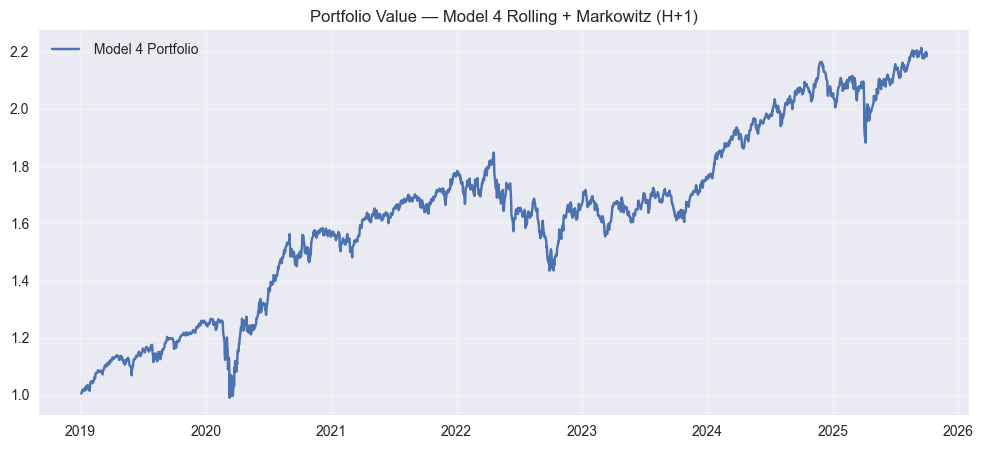

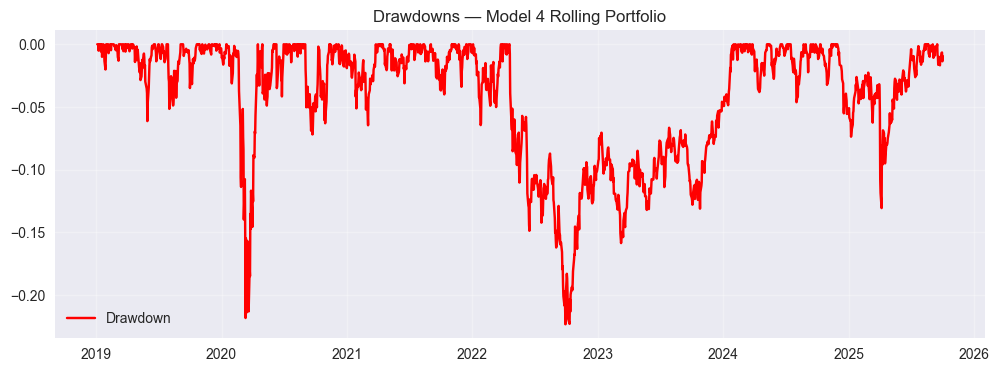

In [94]:
# ------------------------------------------------------------
# 5. Performance (daily horizon returns)
# ------------------------------------------------------------
def max_drawdown(series: pd.Series):
    roll_max = series.cummax()
    dd = series / roll_max - 1.0
    return dd.min(), dd

step_ret = results_resnet["ret_real"].fillna(0.0)
eq       = (1 + step_ret).cumprod()

tot_ret  = eq.iloc[-1] - 1.0
vol      = step_ret.std() * np.sqrt(252)
sharpe   = step_ret.mean() / step_ret.std() * np.sqrt(252)
sortino  = step_ret.mean() / step_ret[step_ret < 0].std() * np.sqrt(252)
mdd, dd  = max_drawdown(eq)

print("\n===  Model 4 → Markowitz (H+1, daily) ===")
print("Total return :", tot_ret)
print("Annual vol   :", vol)
print("Sharpe       :", sharpe)
print("Sortino      :", sortino)
print("Max Drawdown :", mdd)

plt.figure(figsize=(12,5))
plt.plot(eq, label=" Model 4 Portfolio")
plt.grid(alpha=0.3)
plt.legend()
plt.title("Portfolio Value — Model 4 Rolling + Markowitz (H+1)")
plt.show()

plt.figure(figsize=(12,4))
plt.plot(dd, color="red", label="Drawdown")
plt.grid(alpha=0.3)
plt.legend()
plt.title("Drawdowns — Model 4 Rolling Portfolio")
plt.show()


In [95]:
# ============================================================
# 6. CONVERT HYBRID PORTFOLIO TO MONTHLY 
# ============================================================
eq_daily = eq.copy()
eq_model_m = eq_daily.resample("ME").last().dropna()
eq_model_m = eq_model_m / eq_model_m.iloc[0]
r_model_m = eq_model_m.pct_change().dropna()

tot_ret_m = eq_model_m.iloc[-1] / eq_model_m.iloc[0] - 1.0
vol_m     = r_model_m.std() * np.sqrt(12)
sharpe_m  = r_model_m.mean() / r_model_m.std() * np.sqrt(12)
sortino_m = r_model_m.mean() / r_model_m[r_model_m < 0].std() * np.sqrt(12)
mdd_m, dd_m = max_drawdown(eq_model_m)

print("\n=== Hybrid Model 4 (Monthly) ===")
print("Total return:", tot_ret_m)
print("Annual vol :",  vol_m)
print("Sharpe     :",  sharpe_m)
print("Sortino    :",  sortino_m)
print("Max DD     :",  mdd_m)
print("Monthly start:", eq_model_m.index[0])


=== Hybrid Model 4 (Monthly) ===
Total return: 1.0976336939280409
Annual vol : 0.12957319487812752
Sharpe     : 0.9141741545907801
Sortino    : 1.6381058585649406
Max DD     : -0.17436097877225032
Monthly start: 2019-01-31 00:00:00


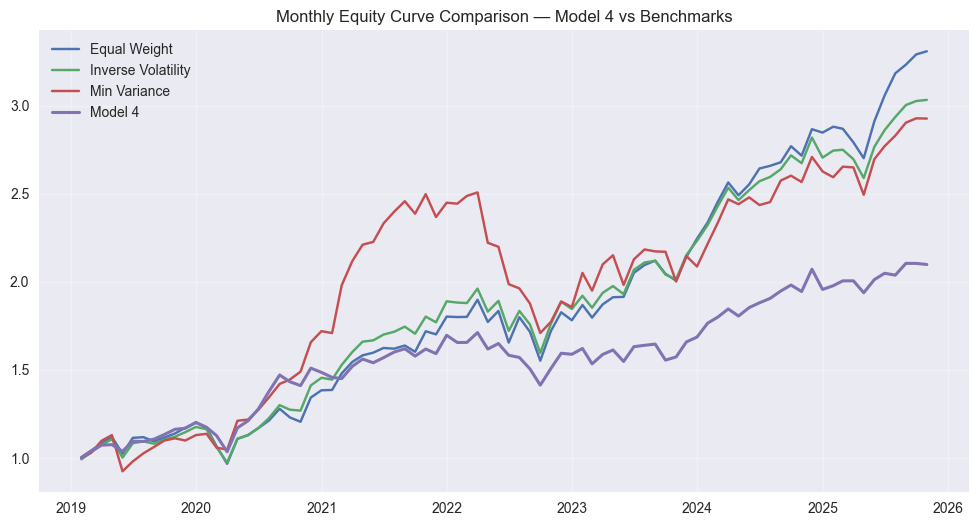

In [ ]:
# ============================================================
# 7. BENCHMARKS (EW / IVOL / MVP) — MONTHLY & ALIGNED
# ============================================================

px_monthly  = px_real[assets].resample("ME").last()
retm_assets = px_monthly.pct_change().dropna()

def run_strategy_bench(retm_assets: pd.DataFrame, method="EW", lookback=6):
    cols = retm_assets.columns
    eq_vals, rets, idx_list = [], [], []

    for t in range(lookback, len(retm_assets)):
        window = retm_assets.iloc[t-lookback:t]

        if method == "EW":
            w = np.ones(len(cols)) / len(cols)

        elif method == "IVOL":
            vol = window.std(ddof=0)
            inv = 1 / vol.replace(0, np.nan)
            w = (inv / inv.sum()).fillna(0.0).values

        elif method == "MVP":
            Sigma = make_psd(window.cov(ddof=0).values)
            n = len(cols)
            w_var = cp.Variable(n)
            prob = cp.Problem(
                cp.Minimize(cp.quad_form(w_var, Sigma)),
                [cp.sum(w_var) == 1, w_var >= 0]
            )
            prob.solve(solver=cp.SCS)
            w = np.array(w_var.value).ravel()

        r_t = retm_assets.iloc[t].values
        port_ret = float(r_t @ w)

        rets.append(port_ret)
        eq_vals.append((1 + port_ret) if len(eq_vals) == 0 else eq_vals[-1] * (1 + port_ret))
        idx_list.append(retm_assets.index[t])

    eq = pd.Series(eq_vals, index=idx_list)
    eq = eq / eq.iloc[0]
    r  = pd.Series(rets, index=idx_list)
    return eq, r


LOOKBACK = 6
eq_EW,   r_EW   = run_strategy_bench(retm_assets, "EW",   LOOKBACK)
eq_IVOL, r_IVOL = run_strategy_bench(retm_assets, "IVOL", LOOKBACK)
eq_MVP,  r_MVP  = run_strategy_bench(retm_assets, "MVP",  LOOKBACK)

common_idx = eq_model_m.index.intersection(eq_EW.index)
plt.figure(figsize=(12,6))
plt.plot(eq_EW.loc[common_idx],    label="Equal Weight")
plt.plot(eq_IVOL.loc[common_idx],  label="Inverse Volatility")
plt.plot(eq_MVP.loc[common_idx],   label="Min Variance")
plt.plot(eq_model_m.loc[common_idx], label="Model 4", linewidth=2.2)
plt.legend()
plt.grid(alpha=0.3)
plt.title("Monthly Equity Curve Comparison — Model 4 vs Benchmarks")
plt.show()

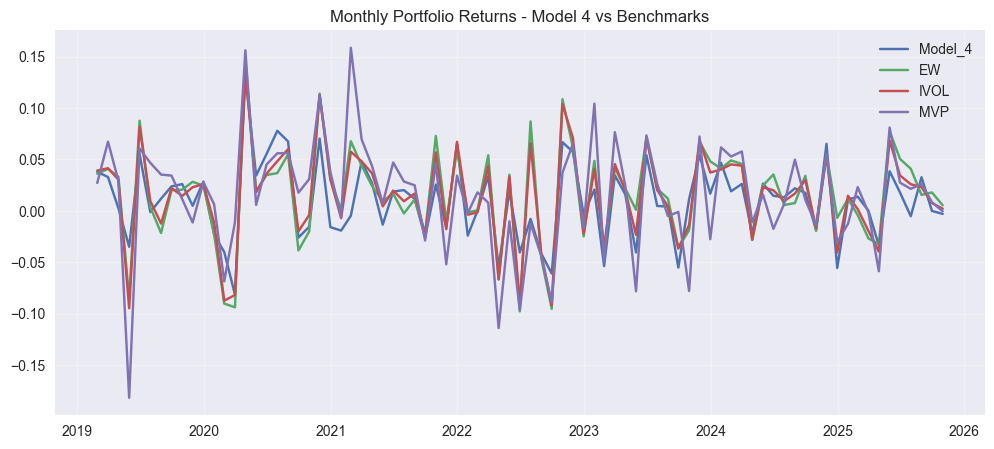

In [97]:
r_model_m = eq_model_m.pct_change().dropna()
r_model_m.name = "Model_4"

r_EW.name = "EW"
r_IVOL.name = "IVOL"
r_MVP.name = "MVP"

ret_df = pd.concat([r_model_m, r_EW, r_IVOL, r_MVP], axis=1).dropna()

plt.figure(figsize=(12,5))
for col in ret_df.columns:
    plt.plot(ret_df.index, ret_df[col], label=col)

plt.legend()
plt.grid(alpha=0.3)
plt.title("Monthly Portfolio Returns - Model 4 vs Benchmarks")
plt.show()


In [98]:
# ============================================================
# 9. PERFORMANCE TABLE (Monthly frequency)
# ============================================================
def perf_metrics(eq: pd.Series):
    r = eq.pct_change().dropna()
    total   = eq.iloc[-1]/eq.iloc[0] - 1
    vol     = r.std() * np.sqrt(12)
    sharpe  = r.mean()/r.std() * np.sqrt(12)
    sortino = r.mean()/r[r < 0].std() * np.sqrt(12)
    mdd     = (eq/eq.cummax() - 1).min()
    return total, vol, sharpe, sortino, mdd


strategies = {
    "Hybrid Rolling": eq_model_m.loc[common_idx],
    "Equal Weight":   eq_EW.loc[common_idx],
    "Inverse Vol":    eq_IVOL.loc[common_idx],
    "Min Variance":   eq_MVP.loc[common_idx]
}

rows = {name: perf_metrics(eq) for name, eq in strategies.items()}

summary = pd.DataFrame.from_dict(
    rows,
    orient="index",
    columns=["Total Return","Volatility","Sharpe","Sortino","Max Drawdown"]
).round(4)

summary

,Total Return,Volatility,Sharpe,Sortino,Max Drawdown
Hybrid Rolling,1.0976,0.1296,0.9142,1.6381,-0.1744
Equal Weight,2.2937,0.1638,1.1663,1.7617,-0.1945
Inverse Vol,2.0566,0.1568,1.1399,1.7069,-0.1863
Min Variance,1.9235,0.1895,0.9389,1.2047,-0.3183


In [99]:
# ============================================
# PERFORMANCE TABLE (Daily frequency)
# ============================================
def perf_metrics_daily(eq: pd.Series):
    r = eq.pct_change().dropna()
    total   = eq.iloc[-1]/eq.iloc[0] - 1
    vol     = r.std() * np.sqrt(252)
    sharpe  = r.mean()/r.std() * np.sqrt(252)
    sortino = r.mean()/r[r<0].std() * np.sqrt(252)
    mdd     = (eq/eq.cummax() - 1).min()
    return total, vol, sharpe, sortino, mdd

strategies_d = {
    "Hybrid Rolling": eq,
    "Equal Weight": (1+r_EW).cumprod(),
    "Inverse Vol":  (1+r_IVOL).cumprod(),
    "Min Variance": (1+r_MVP).cumprod()
}

rows = {name: perf_metrics_daily(eq) for name, eq in strategies_d.items()}

summary_d = pd.DataFrame.from_dict(
    rows,
    orient="index",
    columns=["Total Return","Volatility","Sharpe","Sortino","Max Drawdown"]
).round(4)

summary_d

,Total Return,Volatility,Sharpe,Sortino,Max Drawdown
Hybrid Rolling,1.1830,0.1565,0.8200,1.0474,-0.2233
Equal Weight,2.3078,0.7634,5.0000,7.7300,-0.1945
Inverse Vol,2.0319,0.7303,4.8394,7.3799,-0.1863
Min Variance,1.9260,0.8791,4.0402,5.2554,-0.3183


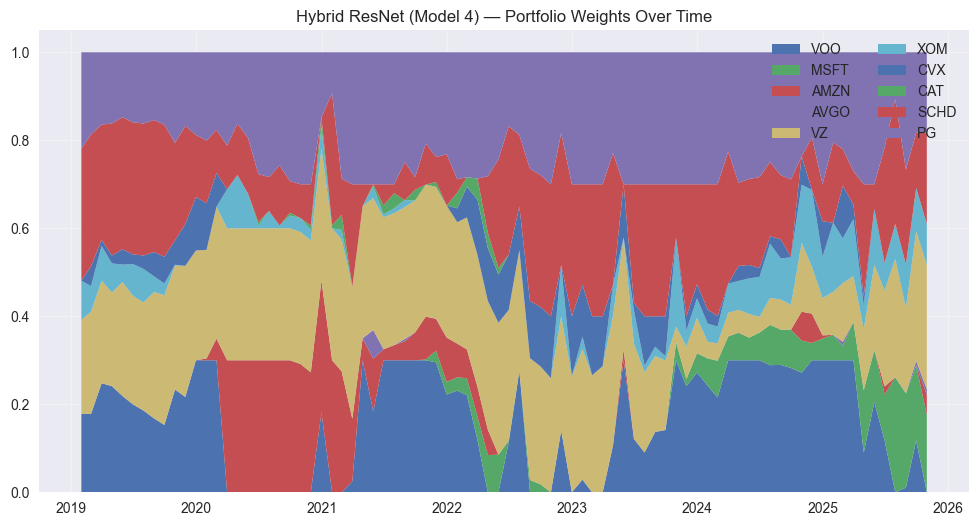

In [ ]:
# ============================================================
# 10. WEIGHTS OVER TIME (Hybrid Rolling)
# ============================================================

weights_roll = pd.DataFrame(results_resnet["weights"].tolist(),index=results_resnet.index)
weights_roll_m = (weights_roll.resample("ME").last().ffill())
plt.figure(figsize=(12,6))
plt.stackplot(weights_roll_m.index,weights_roll_m.T,labels=weights_roll_m.columns)

plt.legend(loc="upper right", ncol=2)
plt.title("Hybrid ResNet (Model 4) Portfolio Weights Over Time")
plt.grid(alpha=0.3)
plt.show()

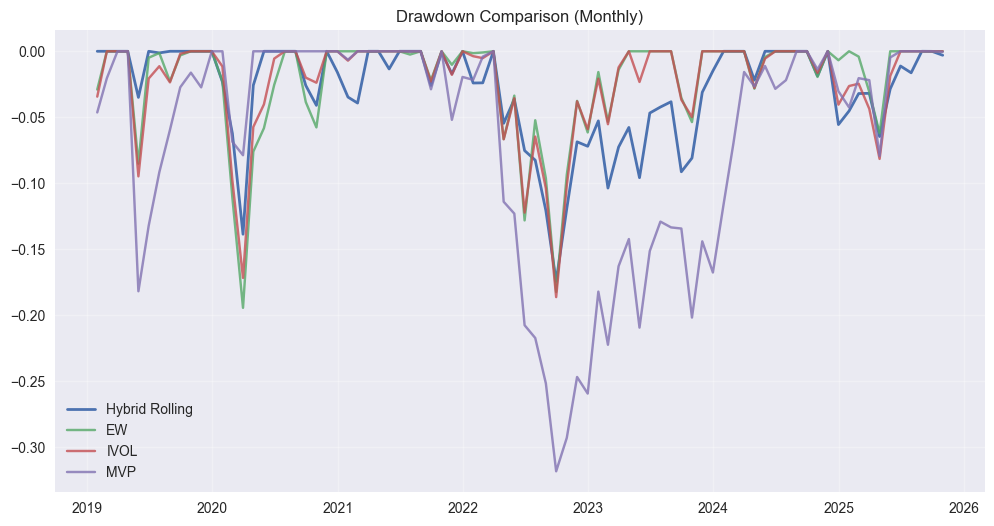

In [101]:
# ============================================================
# X3. Drawdowns Comparison (Monthly)
# ============================================================
def drawdown_series(eq: pd.Series):
    roll_max = eq.cummax()
    return eq / roll_max - 1.0

dd_hybrid = drawdown_series(eq_model_m)  # <-- FIX
dd_EW     = drawdown_series(eq_EW)
dd_IVOL   = drawdown_series(eq_IVOL)
dd_MVP    = drawdown_series(eq_MVP)

common_idx = (
    dd_hybrid.index
    .intersection(dd_EW.index)
    .intersection(dd_IVOL.index)
    .intersection(dd_MVP.index)
)

plt.figure(figsize=(12,6))
plt.plot(common_idx, dd_hybrid.loc[common_idx], label="Hybrid Rolling", lw=2)
plt.plot(common_idx, dd_EW.loc[common_idx],     label="EW",   alpha=0.8)
plt.plot(common_idx, dd_IVOL.loc[common_idx],   label="IVOL", alpha=0.8)
plt.plot(common_idx, dd_MVP.loc[common_idx],    label="MVP",  alpha=0.8)

plt.legend()
plt.grid(alpha=0.3)
plt.title("Drawdown Comparison (Monthly)")
plt.show()

In [103]:
df_eq = pd.concat([eq_model_m.rename("Hybrid"),eq_EW.rename("EW"),eq_IVOL.rename("IVOL"),eq_MVP.rename("MVP")], axis=1)
df_eq.index.name = "date"
df_eq.to_csv(r"E:\data\equity_curves_monthly.csv")
df_eq

,Hybrid,EW,IVOL,MVP
date,,,,
2018-08-31,NaN,1.000000,1.000000,1.000000
2018-09-30,NaN,1.034277,1.027214,1.035182
2018-10-31,NaN,0.963641,0.964298,0.986594
2018-11-30,NaN,1.015581,1.011154,1.049480
2018-12-31,NaN,0.947649,0.939929,0.945726
...,...,...,...,...
2025-06-30,2.047862,3.057242,2.860601,2.769368
2025-07-31,2.037219,3.182643,2.934817,2.828770
2025-08-31,2.103976,3.232049,3.002583,2.902748


In [104]:
df_ret = pd.concat([r_model_m.rename("Hybrid"),r_EW.rename("EW"),r_IVOL.rename("IVOL"),r_MVP.rename("MVP")], axis=1)
df_ret.index.name = "date"
df_ret.to_csv(r"E:\data\returns_monthly.csv")
df_ret

,Hybrid,EW,IVOL,MVP
date,,,,
2018-08-31,NaN,0.022298,0.029402,0.044997
2018-09-30,NaN,0.034277,0.027214,0.035182
2018-10-31,NaN,-0.068295,-0.061249,-0.046937
2018-11-30,NaN,0.053899,0.048591,0.063740
2018-12-31,NaN,-0.066889,-0.070439,-0.098862
...,...,...,...,...
2025-06-30,0.017854,0.050508,0.034424,0.027462
2025-07-31,-0.005197,0.041018,0.025944,0.021450
2025-08-31,0.032769,0.015524,0.023090,0.026152


In [105]:
dd_df = pd.concat([dd_hybrid.rename("Hybrid"),dd_EW.rename("EW"),dd_IVOL.rename("IVOL"),dd_MVP.rename("MVP")], axis=1)
dd_df.index.name = "date"
dd_df.to_csv(r"E:\data\drawdowns_monthly_all.csv")
dd_df

,Hybrid,EW,IVOL,MVP
date,,,,
2018-08-31,NaN,0.000000,0.000000,0.000000
2018-09-30,NaN,0.000000,0.000000,0.000000
2018-10-31,NaN,-0.068295,-0.061249,-0.046937
2018-11-30,NaN,-0.018077,-0.015634,0.000000
2018-12-31,NaN,-0.083757,-0.084972,-0.098862
...,...,...,...,...
2025-06-30,-0.011175,0.000000,0.000000,0.000000
2025-07-31,-0.016314,0.000000,0.000000,0.000000
2025-08-31,0.000000,0.000000,0.000000,0.000000


In [106]:
weights_roll_m.to_csv(r"E:\data\Model4_data\weights_monthly.csv", index_label="date")
weights_roll_m

,VOO,MSFT,AMZN,AVGO,VZ,XOM,CVX,CAT,SCHD,PG
date,,,,,,,,,,
2019-01-31,1.787096e-01,-5.886856e-18,-7.890533e-18,-4.248444e-18,0.213392,0.088812,5.709716e-19,-3.881439e-18,0.300000,0.219086
2019-02-28,1.777212e-01,-1.212163e-17,-1.528304e-17,-7.688110e-18,0.232657,0.058199,4.455930e-02,-8.124243e-18,0.300000,0.186863
2019-03-31,2.478815e-01,-1.556299e-17,-1.501890e-19,-1.678276e-17,0.233071,0.078877,1.413582e-02,-1.188283e-17,0.261794,0.164241
2019-04-30,2.412274e-01,-2.430639e-17,-3.166218e-17,-1.959550e-17,0.212954,0.066103,1.783458e-02,-1.867534e-17,0.300000,0.161881
2019-05-31,2.186635e-01,-2.272049e-17,-2.902149e-17,-1.840584e-17,0.259170,0.039531,3.518862e-02,-1.666759e-17,0.300000,0.147447
...,...,...,...,...,...,...,...,...,...,...
2025-06-30,1.175079e-01,1.047455e-01,1.817151e-02,7.641272e-06,0.218166,0.062528,8.458695e-06,-1.487637e-05,0.262832,0.216048
2025-07-31,-8.111404e-18,2.613242e-01,-9.939905e-18,-7.157590e-18,0.269216,0.079610,-1.741517e-18,-1.301399e-17,0.283435,0.106415
2025-08-31,1.052362e-02,2.138449e-01,1.048138e-16,1.175313e-03,0.193500,0.099080,1.473683e-17,6.554086e-17,0.215200,0.266675


In [107]:
print("\n" + "="*60)
print("MODEL 4 — AUDIT SUMMARY")
print("="*60)

# --------------------------------------------------
# 1) ASSET UNIVERSE
# --------------------------------------------------
print("\n[ASSETS]")
print("N assets:", len(assets))
print("Assets list:", assets)

# --------------------------------------------------
# 2) RAW PRICE DATA
# --------------------------------------------------
print("\n[PRICE DATA]")
print("Shape:", px_real.shape)
print("Date range:", px_real.index.min(), "→", px_real.index.max())
print("Columns match assets:",
      set(assets).issubset(px_real.columns))

# --------------------------------------------------
# 3) RETURNS USED FOR COVARIANCE
# --------------------------------------------------
print("\n[HISTORICAL RETURNS]")
print("rets_all shape:", rets_all.shape)
print("rets_all start/end:",
      rets_all.index.min(),
      rets_all.index.max())

# --------------------------------------------------
# 4) FORECAST MATRICES
# --------------------------------------------------
print("\n[FORECAST MATRICES]")
print("r_hat_df:", r_hat_df.shape)
print("r_real_df:", r_real_df.shape)

print("Forecast index start/end:",
      r_hat_df.index.min(),
      r_hat_df.index.max())

# --------------------------------------------------
# 5) ROLLING MARKOWITZ OUTPUT
# --------------------------------------------------
print("\n[ROLLING MARKOWITZ]")
print("results_resnet shape:", results_resnet.shape)
print("Start:", results_resnet.index.min())
print("End:", results_resnet.index.max())

# --------------------------------------------------
# 6) DAILY PORTFOLIO
# --------------------------------------------------
print("\n[DAILY PORTFOLIO]")
print("Equity length:", len(eq))
print("Start:", eq.index.min())
print("End:", eq.index.max())

# --------------------------------------------------
# 7) MONTHLY PORTFOLIO
# --------------------------------------------------
print("\n[MONTHLY PORTFOLIO]")
print("eq_model_m length:", len(eq_model_m))
print("Monthly start:", eq_model_m.index.min())
print("Monthly end:", eq_model_m.index.max())

# --------------------------------------------------
# 8) BENCHMARK INPUT DATA
# --------------------------------------------------
print("\n[BENCHMARK INPUT]")
print("retm_assets shape:", retm_assets.shape)
print("retm_assets start/end:",
      retm_assets.index.min(),
      retm_assets.index.max())

# --------------------------------------------------
# 9) BENCHMARK OUTPUTS
# --------------------------------------------------
print("\n[BENCHMARK OUTPUTS]")
print("EW length:", len(eq_EW),
      "| start:", eq_EW.index.min(),
      "| end:", eq_EW.index.max())

print("IVOL length:", len(eq_IVOL),
      "| start:", eq_IVOL.index.min(),
      "| end:", eq_IVOL.index.max())

print("MVP length:", len(eq_MVP),
      "| start:", eq_MVP.index.min(),
      "| end:", eq_MVP.index.max())

# --------------------------------------------------
# 10) ALIGNMENT CHECK
# --------------------------------------------------
print("\n[ALIGNMENT CHECK]")

common = eq_model_m.index.intersection(eq_EW.index)

print("Common months Model vs EW:", len(common))
print("Model start vs EW start:",
      eq_model_m.index.min(),
      eq_EW.index.min())

print("Model end vs EW end:",
      eq_model_m.index.max(),
      eq_EW.index.max())

# --------------------------------------------------
# 11) NaN CHECKS
# --------------------------------------------------
print("\n[NaN CHECKS]")

print("NaNs in eq_model_m:", eq_model_m.isna().sum())
print("NaNs in EW:", eq_EW.isna().sum())
print("NaNs in IVOL:", eq_IVOL.isna().sum())
print("NaNs in MVP:", eq_MVP.isna().sum())

print("\n" + "="*60)
print("END AUDIT")
print("="*60)



MODEL 4 — AUDIT SUMMARY

[ASSETS]
N assets: 10
Assets list: ['VOO', 'MSFT', 'AMZN', 'AVGO', 'VZ', 'XOM', 'CVX', 'CAT', 'SCHD', 'PG']

[PRICE DATA]
Shape: (1950, 10)
Date range: 2018-01-02 00:00:00 → 2025-10-03 00:00:00
Columns match assets: True

[HISTORICAL RETURNS]
rets_all shape: (1949, 10)
rets_all start/end: 2018-01-03 00:00:00 2025-10-03 00:00:00

[FORECAST MATRICES]
r_hat_df: (1909, 10)
r_real_df: (1909, 10)
Forecast index start/end: 2018-03-01 00:00:00 2025-10-02 00:00:00

[ROLLING MARKOWITZ]
results_resnet shape: (1696, 4)
Start: 2019-01-04 00:00:00
End: 2025-10-02 00:00:00

[DAILY PORTFOLIO]
Equity length: 1696
Start: 2019-01-04 00:00:00
End: 2025-10-02 00:00:00

[MONTHLY PORTFOLIO]
eq_model_m length: 82
Monthly start: 2019-01-31 00:00:00
Monthly end: 2025-10-31 00:00:00

[BENCHMARK INPUT]
retm_assets shape: (93, 10)
retm_assets start/end: 2018-02-28 00:00:00 2025-10-31 00:00:00

[BENCHMARK OUTPUTS]
EW length: 87 | start: 2018-08-31 00:00:00 | end: 2025-10-31 00:00:00
IVOL l